# Modeling Decay Chains - 232Th and 235U
235-Uranium and 232-Thorium are radioactive isotopes which are known to be fairly abundant in the surrounding rock and walls at SNOLAB. SOURCES is a computational code that takes levels of radioactive contamination in materials and outputs the neutron source strengths they induce in terms of ($\alpha$,n) and spontaneous fission (SF). The Radiation Safety Information Computational Center (RSICC)[[RSICC][RSICC]] maintains and distributes the SOURCES code. The exact relative abundances of isotopes in the 232-Thorium and 235-Uranium decay chains at SNOLAB is unknown. The inputs for the SOURCES4C code assumes secular equilibrium for both decay chains. Here, the relative abundances of alpha decayers present in decay chains over the timescales of 232-Th and 235-U half-lives respectively, are plotted to ensure this assumption is reasonable. The counts of each isotope are calculated abiding by the differential equations outlined here: [[Decay chain differential equations: Solutions through matrix analysis][DiffEqs]]. 

[DiffEqs]:https://www.sciencedirect.com/science/article/pii/S0010465518302613 "Decay Chain solutions thru matrix analysis"
[RSICC]: https://www.ornl.gov/onramp/rsicc "Oak Ridge Computational Page"

In [1]:
import numpy as np
import pandas as pd
import math
import random

class Isotope:
    def __init__(self, name, half_life, decay_modes, count=0, is_stable=False):

        self.name = name
        self.half_life = half_life
        self.decay_modes = decay_modes
        self.count = count
        self.is_stable = is_stable

    def decay(self):
        if self.is_stable or not self.decay_modes:
            return ("stable", self.name)

        r = random.random()
        cumulative = 0.0
        for mode, daughter, prob in self.decay_modes:
            cumulative += prob
            if r < cumulative:
                return (mode, daughter)
        # Fallback in case of rounding errors
        return self.decay_modes[-1]

    def time_until_decay(self):
        return random.expovariate(math.log(2) / self.half_life)

In [2]:
decay_data = {
    "Ra_228": {
        "half_life": 5.7 * 365 * 24 * 3600,
        "decay_modes": [("beta", "Ac_228", 1.0)]
    },
    "Ac_228": {
        "half_life": 6.1 * 60,
        "decay_modes": [("beta", "Th_228", 1.0)]
    },
    "Th_228": {
        "half_life": 1.9 * 365 * 24 * 3600,
        "decay_modes": [("alpha", "Ra_224", 1.0)]
    },
    "Ra_224": {
        "half_life": 3.6 * 24 * 3600,
        "decay_modes": [("alpha", "Rn_220", 1.0)]
    },
    "Rn_220": {
        "half_life": 55,
        "decay_modes": [("alpha", "Po_216", 1.0)]
    },
    "Po_216":{
        "half_life":  0.14,
        "decay_modes": [("alpha", "Pb_212", 1.0)]
    },
    "Pb_212":{
        "half_life":  10.6 * 3600,
        "decay_modes": [("beta", "Bi_212", 1.0)]
    },
    "Bi_212":{
        "half_life":  61 * 60,
        "decay_modes": [("beta", "Po_212", 0.6406),
                        ("alpha", "Tl_208", 0.3594)]
    },
    "Po_212":{
        "half_life":  3e-7,
        "decay_modes": [("alpha","Pb_208", 1.0)]
    },
    "Tl_208":{
        "half_life": 3.1 * 60,
        "decay_modes": [("beta", "Pb_208", 1.0)]}
    # Pb 208 is stable define separately
}

Th_232 = Isotope("Th_232", 1.41e10 * 365 * 24 * 3600, [("alpha", "Ra_228", 1.0)], 6e23)
# Build Isotope objects
Pb_208 = Isotope("Pb_208", float('inf'), [], is_stable=True)

print(1.41e10 * 365 * 24 * 3600)
isotopes = {}
for name, data in decay_data.items():
    isotopes[name] = Isotope(name, data["half_life"], data["decay_modes"])

# List of Isotope instances
isotope_list = [Th_232] + list(isotopes.values()) + [Pb_208]
# print(isotope_list)
# lambda_list = []

# for i in isotope_list:
#     lambda_list.append(math.log(2)/i.half_life)
    


4.446576e+17


<class 'list'>
[-935300.1238165437, 935300.1238165437, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


C:\Users\cecih\AppData\Local\Temp\ipykernel_22832\679131223.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(new_ticks / 1.41e10 * 365 * 24 * 3600)


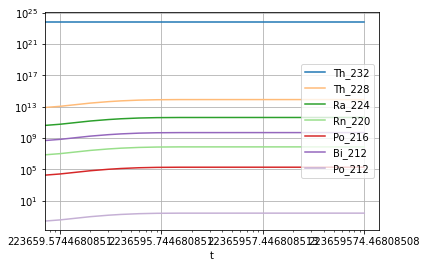

4446576000.0


In [3]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

name_to_index = {iso.name: idx for idx, iso in enumerate(isotope_list)}

#Initial Counts
y0=[]
for i in isotope_list:
    y0.append(i.count)

print(type(isotope_list))
# Sum over j<n: br(j->n)*lambda_j*N_n - lambda_n*N_n
def returns_dydt(t, y, isotopes):
    dydt = [0.0] * len(isotopes)
    branching_ratios=[]
    for i, isotope in enumerate(isotopes):
        lambda_i = math.log(2) / isotope.half_life
        dydt[i] -= lambda_i * y[i] #it thinks y is a float not list????
        for j, parent in enumerate(isotopes):
            for mode, daughter_name, br in parent.decay_modes:
                if daughter_name == isotope.name:
                    lambda_j = math.log(2) / parent.half_life
                    branching_ratios.append(br)
                    dydt[i]+=br*(math.log(2)/parent.half_life)*y[j]
                else:
                    branching_ratios.append(0)
                    dydt[i]+=0
    

    return dydt

#normalize using lambda?
#set initial condition
t_max = 10e10
# t_max = Th_232.half_life
t_points = 999
t = np.linspace(0, t_max, t_points)
# solving ODE
print(returns_dydt(t, y0, isotope_list))


sol_y = solve_ivp(returns_dydt, [0, t_max], y0, args=(isotope_list,), method='BDF', t_eval=t)

# plot results ignore for now
import matplotlib.pyplot as plt
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(12)]

for i, isotope in enumerate(isotope_list):
    # print(isotope.name)
    # print(isotope.decay_modes[0])
    # print(any('alpha' in sublist for sublist in isotope.decay_modes))
    if (any('alpha' in sublist for sublist in isotope.decay_modes)) & (isotope.name != "Pb_208"):
        plt.plot(sol_y.t, sol_y.y[i], label=isotope.name, color=colors[i])
plt.legend(loc='right')
plt.yscale('log')
plt.xscale('log')
# plt.ylim(0,10000000)
new_ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(new_ticks / 1.41e10 * 365 * 24 * 3600)
plt.xlabel('t')
plt.grid()
plt.show()

print(10e-9*Th_232.half_life)


## To Do

2. Plot relative abundances rather than # of each isotope
3. plot in terms of th half lives - fix the weirdness

# Modeling Decay Chain for Uranium 235

In [4]:
decay_data1 = {
    "Th_231": {
        "half_life": 25.52 * 3600,
        "decay_modes": [("beta", "Pa_231", 1.0)]
    },
    "Pa_231": {
        "half_life": 32760 * 365 * 24 * 3600,
        "decay_modes": [("beta", "Ac_227", 1.0)]
    },
    "Ac_227": {
        "half_life": 21.772 * 365 * 24 * 3600,
        "decay_modes": [("alpha", "Fr_223", 0.0138),
                       ("beta", "Th_227", 0.9862)]
    },
    "Th_227": {
        "half_life": 18.68 *24*3600,
        "decay_modes": [("alpha", "Ra_223", 1)]
    },
    "Ra_223": {
        "half_life": 11.43 *24*3600,
        "decay_modes": [("alpha", "Rn_219", 1)]
    },
    "Fr_223": {
        "half_life": 22 * 60,
        "decay_modes": [("alpha", "Ra_223", 0.00006),
                       ("beta", "At_219", 0.99994)]
    },
    "At_219": {
        "half_life": 56,
        "decay_modes": [("alpha", "Bi_215", 0.936),
                       ("beta", "Rn_219", 0.064)]
    },
    "Rn_219": {
        "half_life": 3.93,
        "decay_modes": [("alpha", "Po_215", 1)]
    },
    "Bi_215": {
        "half_life": 7.6 * 60,
        "decay_modes": [("beta", "Po_215", 1)]
    },
    "Po_215": {
        "half_life": 1.781e-3,
        "decay_modes": [("alpha", "Pb_211", 0.9999977),
                       ("beta", "At_215", 0.0000023)]
    },
    "At_215": {
        "half_life": 1e-4,
        "decay_modes": [("alpha", "Bi_211", 1)]
    },
    "Pb_211":{
        "half_life": 36.1 * 60,
        "decay_modes": [("beta", "Bi_211", 1)]
    },
    "Bi_211":{
        "half_life": 2.14 * 60,
        "decay_modes": [("alpha", "Tl_207", 0.99724), 
                        ("beta","Po_211", 0.00276)]
    },
    "Po_211":{
        "half_life": 0.516,
        "decay_modes":[("alpha", "Pb_207", 1)]
    },
    "Tl_207":{
        "half_life": 4.77 * 60,
        "decay_modes":[("beta", "Pb_207", 1)]
    }
}

#Define Parent outside dictionary bc need to identify count, and stable daughter
U_235 = Isotope("U_235", 7.04e8*365*24*3600, [("alpha", "Th_231", 1.0)], 6e23)
Pb_207 = Isotope("Pb_207", float('inf'), [], is_stable=True)

isotopes1 = {}
for name, data in decay_data1.items():
    isotopes1[name] = Isotope(name, data["half_life"], data["decay_modes"])

# List of Isotope instances
isotope_list1 = [U_235] + list(isotopes1.values()) + [Pb_207]

C:\Users\cecih\AppData\Local\Temp\ipykernel_22832\3668616324.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f"{tick:.2g}" for tick in new_ticks])


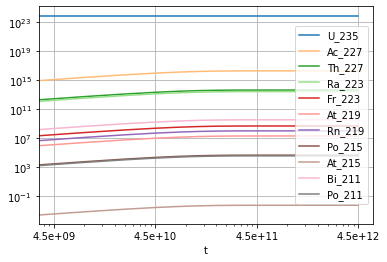

In [13]:
from math import floor
#Initial Counts
y0_U=[]
for i in isotope_list1:
    y0_U.append(i.count)
    
#set initial condition
t_max = 10e13
# t_max = Th_232.half_life
t_points = 999
t = np.linspace(0, t_max, t_points)
# solving ODE
sol_y1 = solve_ivp(returns_dydt, [0, t_max], y0_U, method='BDF', t_eval=t, args=(isotope_list1,))

# plot results ignore for now
import matplotlib.pyplot as plt
cmap1 = plt.get_cmap('tab20')
colors = [cmap1(i) for i in range(17)]

for i, isotope in enumerate(isotope_list1):
    # print(isotope.name)
    # print(isotope.decay_modes[0])
    # print(any('alpha' in sublist for sublist in isotope.decay_modes))
    if (any('alpha' in sublist for sublist in isotope.decay_modes)) & (isotope.name != "Pb_208"):
        plt.plot(sol_y1.t, sol_y1.y[i], label=isotope.name, color=colors[i])
plt.legend(loc='right')
plt.yscale('log')
plt.xscale('log')
# plt.ylim(0,10000000)
new_ticks = plt.gca().get_xticks()/ 7.04e8*365*24*3600
plt.gca().set_xticklabels([f"{tick:.2g}" for tick in new_ticks])
plt.xlabel('t')
plt.grid()
plt.show()

